## 3. Data format

Which analyses or experiments did you perform and what are the results? Choose suitable visualizations to show your results.

How do the results relate to your hypotheses?

Did you find interesting or unexpected things? How do they influence your project?

What are problems that you encountered? How could you plan to deal with them?


Do the analyses and results make sense? How can they be interpreted?

What are the next steps in the project?

Which aspects of your findings do you want to put in the center?

Which ones do you decide not to pursue further?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [192]:
# load sample data
sample_dir = 'data/anglophone/'

gangsta_files = ['50Cent_CandyShop.rap',
'50Cent_DiscoInferno.rap',
'50Cent_InDaClub.rap',
'50Cent_JustALilBit.rap',
'50Cent_P.I.M.P..rap',
'Eminem_TheWayIAm.rap',
'JayZ_CanIGetA.rap',
'JayZ_HolyGrail.rap',
'JayZ_NiggasInParis.rap',
'KanyeWest_Clique.rap',
'KanyeWest_Mercy.rap',
'LilWayne_AMilli.rap',
'LilWayne_GotMoney.rap',
'LilWayne_Lollipop.rap',
'Ludacris_HowLow.rap',
'Ludacris_MoveBitch.rap',
'Ludacris_StandUp.rap',
'Ludacris_WhatsYourFantasy.rap',
'Mims_ThisIsWhyImHot.rap',
'MissyElliott_WorkIt.rap',
'Nelly_Grillz.rap',
'SnoopDogg_LayLow.rap',
'SnoopDogg_Woof.rap',
'T.I._LiveYourLife.rap',
'T.I._WhatYouKnow.rap',
'TerrorSquad_LeanBack.rap']

oldschool_files=[
'2pac_CaliforniaLove.rap',
'2pac_HowDoUWantIt.rap',
'2pac_IGetAround.rap',
'2pac_PapazSong.rap',
'2pac_SoManyTears.txt',
'DrDre_NuthinButAGThang.rap',
'Eminem_RockBottom.rap',
'Eminem_TheRealSlimShady.rap',
'JayZ_CantKnockTheHustle.rap',
'KrisKross_Jump.rap',
'LLCoolJ_HeyLover.rap',
'LLCoolJ_INeedLove.rap',
'NotoriousBIG_BigPoppa.rap',
'NotoriousBIG_GoingBackToCali.rap',
'NotoriousBIG_Hypnotize.rap',
'NotoriousBIG_Juicy.rap',
'NotoriousBIG_MoMoneyMoProblems.rap',
'NotoriousBIG_OneMoreChance.rap',
'NotoriousBIG_SkysTheLimit.rap',
'Run-D.M.C._DownWithTheKing.rap',
'SnoopDogg_GinAndJuice.rap',
'WarrenG_Regulate.rap',
'WillSmith_GettinJiggyWitIt.rap',
'WillSmith_Summertime.rap',
'WillSmith_WildWildWest.rap',
'Wreckx-N-Effect_RumpShaker.rap',
]

In [328]:
def _convert_recip(string, ref):
    if '=' in string:
        return string
    else:    
        dots = string.count('.')
        num = int(string.strip('.'))
        coef = 1
        for d in range(dots):
            coef += 1 / (2**(d+1))

        return coef * ref / num
        

class HumdrumSummary():
    def __init__(self, sample_path):
        raw_df =  pd.read_table(sample_path)
        
        df = raw_df[raw_df['**recip'].apply(lambda x: '!' not in x)]
        
        meter = tuple(map(lambda x: int(x), \
                         df['**recip'][df['**recip'].apply(lambda x: '/' in x)].unique()[0].strip('*M').split('/')))
        tempo = int(df['**recip'][df['**recip'].apply(lambda x: '*MM' in x)].unique()[0].strip('*MM'))             

        
    
        df = df[df['**recip'].apply(lambda x: x[0] in '0123456789=')]
        df['**recip'] = df['**recip'].apply(lambda x: _convert_recip(string=x,ref=meter[1]))             
        
        
        if (df['**recip'] == '=0').any():

            pickup_start = df[df['**recip'].apply(lambda x: x == '=0')].index
            pickup_end = df[df['**recip'].apply(lambda x: x == '=1')].index

            for i, idx in enumerate(pickup_start):
                snippet = df.loc[idx+1:pickup_end[i]-1]
                #rest = meter[0] - snippet['**recip'][snippet['**lyrics']!='.'].sum()
                snippet['**recip'][snippet['**lyrics']=='.'] = 0
                rest = meter[0] - snippet['**recip'][snippet['**lyrics']!='.'].sum()
                snippet['**recip'].at[idx+1] = rest
        
        df = df[df['**recip'].apply(lambda x: type(x) != str)]
        df = df[df['**recip'] != 0]
        df['cum_recip'] = df['**recip'].cumsum()-0.1

    
        self.meter = meter
        self.tempo = tempo
        self.df = df
        self.raw_df = raw_df
        self.clean_df = df[df['**recip'].apply(lambda x: type(x) == float)]

        
        
        self.syl_onsets = df[df['**lyrics']!='.'].shape[0]
        self.syllabic_rate = tempo / (df['**recip'][df['**lyrics']!='.'].mean() * 60) # or total number of measures, divided by.. 
        
        self.measures = raw_df


        
        
    
    def phrase_based(self):
        # according to the description on the website and our common knowledge of interpreting the lyrics,
        # we concluded that only level 3,4 break are meaningful.
        sample_clean = self.df
#        sample_clean = sample_clean[sample_clean['**lyrics']!='.']

        breaks_idx = sample_clean[sample_clean['**break'].apply(lambda x: x in ['3','4'])].index
        # add closing break point

        # create a new dataframe that will show the flowwise analysis on this song
        sample_flowwise = pd.DataFrame(columns=['recip','lyric'])


        for i in range(breaks_idx.shape[0]-1):
            (start, end) = (breaks_idx[i], breaks_idx[i+1])
            snippet = sample_clean.loc[start:end-1]
            sample_flowwise.at[i,'recip'] = snippet['**recip'].values
            sample_flowwise.at[i,'lyric'] = ' '.join(snippet['**lyrics'].values)

        maxlen = sample_flowwise.lyric.apply(lambda x: len(x)).max()
        pd.set_option('display.max_colwidth', maxlen)
        return sample_flowwise
    
    
    
    def rest_based(self):
        sample_clean = self.clean_df
        breaks_idx = sample_clean[sample_clean['**ipa']=='R'].index

        sample_flowwise = pd.DataFrame(columns=['recip','lyric'])
        for i in range(breaks_idx.shape[0]-1):
            (start, end) = (breaks_idx[i], breaks_idx[i+1])
            snippet = sample_clean.iloc[start:end-1]
            sample_flowwise.at[i,'recip'] = snippet['**recip'].values
            sample_flowwise.at[i,'lyric'] = ' '.join(snippet['**lyrics'].values)

            # convert into string, so that we can easily examine if the encoding is done correctly (we will check this with each song)
        maxlen = sample_flowwise.recip.apply(lambda x: len(x)).max()
        pd.set_option('display.max_colwidth', maxlen)
        return sample_flowwise

    
#    def rhyme_position_dist(self)
    # self.df_norm
    # get the '=0' line and =1 line -> pad the first 
        

    
        
        
    
        
def flowwise_visualize(flowwise_df):
    sample = flowwise_df
    maxlen = sample.recip.apply(lambda x: len(x)).max()
    sample.recip = sample.recip.apply(lambda x: np.concatenate([x, [0]* (maxlen - len(x))]))
    s = pd.DataFrame(item for item in sample.recip)

    viz = s.plot(kind='bar', stacked=True, legend=None)
    plt.xticks([])
    return viz
    
    

In [260]:
sample_path

'data/anglophone/Gangsta/TerrorSquad_LeanBack.rap'

In [287]:
sample_path
sample = HumdrumSummary(sample_path)
df = sample.df

df['**recip'].sum()/4

/Users/haeeunkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


49.0

In [327]:
df['cum_recip']-0.1

5         2.9
6        3.15
7         3.4
8        3.65
9         3.9
        ...  
661    194.65
662     194.9
663     195.4
664    195.65
665     195.9
Name: cum_recip, Length: 608, dtype: object

In [ ]:
df

In [ ]:
flowwise_visualize(sample.phrase_based())

In [ ]:
sample.df[sample.df['**lyrics']!='R']

In [239]:
oldschool_error = []
summary_os = {'tempo':[],'meter':[], 'syl_onsets':[], 'syllabic_rate':[]}
for i, f in enumerate(oldschool_files):
    try:
        sample_path = sample_dir + 'Old School/' + f
        sample = HumdrumSummary(sample_path)
        summary_os['tempo'].append(sample.tempo)
        summary_os['meter'].append(sample.meter)
        summary_os['syl_onsets'].append(sample.syl_onsets)
        summary_os['syllabic_rate'].append(sample.syllabic_rate)
        
    except:
        error.append(sample_path)
        pass


/Users/haeeunkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


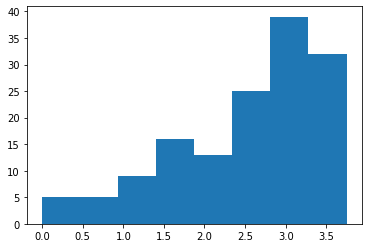

In [321]:

plt.hist(df[df['**rhyme']!='.'].cum_recip.apply(lambda x: x % 4), bins=8)
plt.show()


data/anglophone/Gangsta/50Cent_CandyShop.rap


/Users/haeeunkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


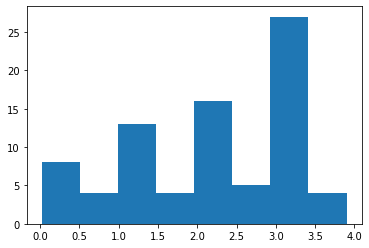

data/anglophone/Gangsta/50Cent_DiscoInferno.rap


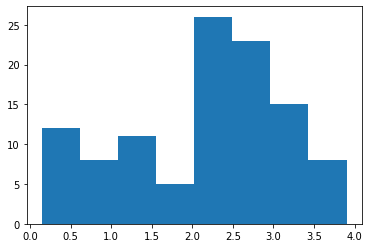

data/anglophone/Gangsta/50Cent_InDaClub.rap


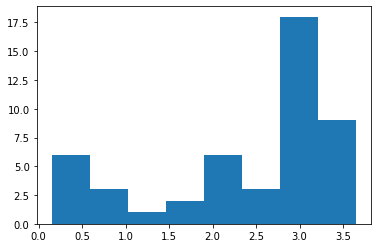

data/anglophone/Gangsta/50Cent_P.I.M.P..rap


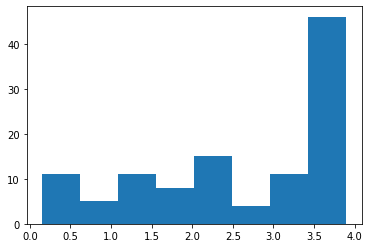

data/anglophone/Gangsta/Eminem_TheWayIAm.rap


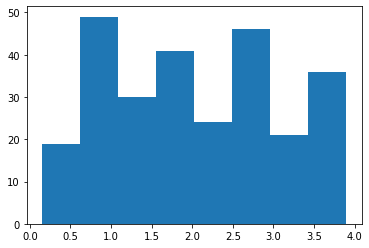

data/anglophone/Gangsta/JayZ_CanIGetA.rap


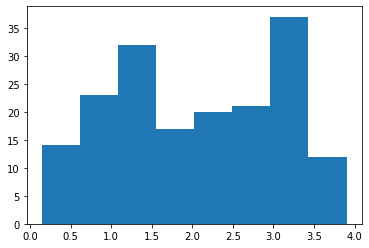

data/anglophone/Gangsta/JayZ_HolyGrail.rap


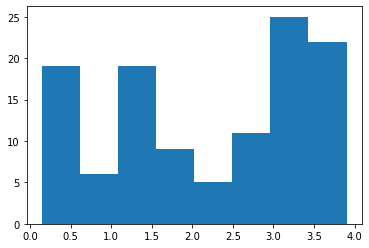

data/anglophone/Gangsta/KanyeWest_Clique.rap


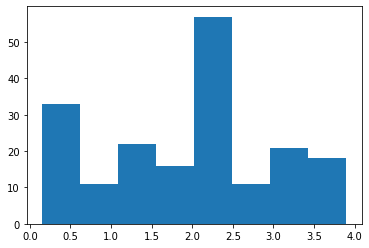

data/anglophone/Gangsta/KanyeWest_Mercy.rap


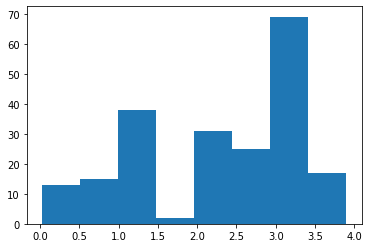

data/anglophone/Gangsta/LilWayne_GotMoney.rap


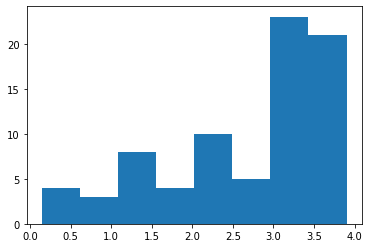

data/anglophone/Gangsta/LilWayne_Lollipop.rap


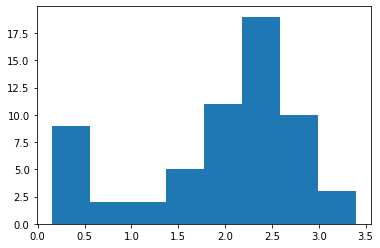

data/anglophone/Gangsta/Ludacris_HowLow.rap


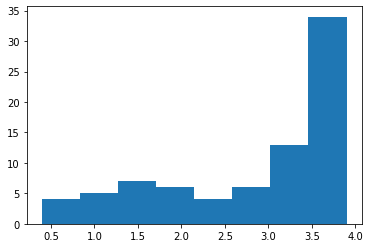

data/anglophone/Gangsta/Ludacris_MoveBitch.rap


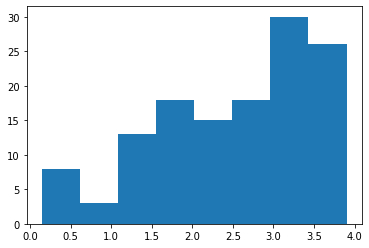

data/anglophone/Gangsta/Ludacris_StandUp.rap


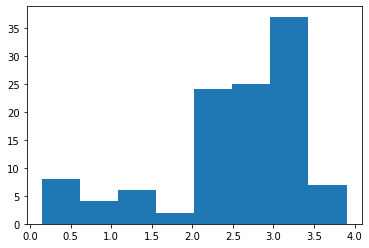

data/anglophone/Gangsta/Ludacris_WhatsYourFantasy.rap


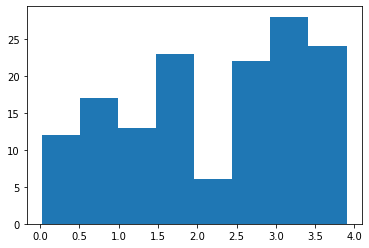

data/anglophone/Gangsta/Mims_ThisIsWhyImHot.rap


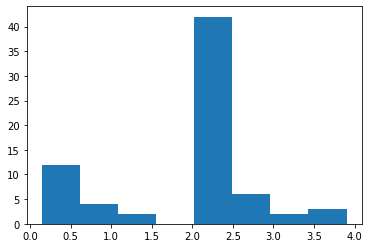

data/anglophone/Gangsta/MissyElliott_WorkIt.rap


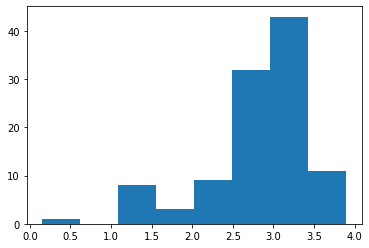

data/anglophone/Gangsta/Nelly_Grillz.rap


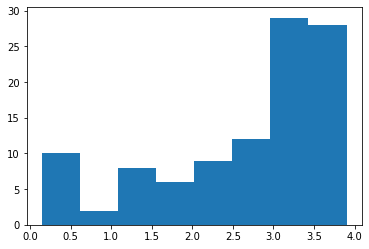

data/anglophone/Gangsta/SnoopDogg_LayLow.rap


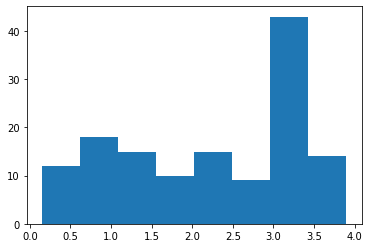

data/anglophone/Gangsta/T.I._WhatYouKnow.rap


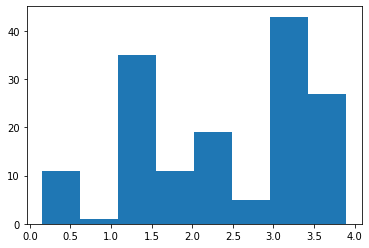

data/anglophone/Gangsta/TerrorSquad_LeanBack.rap


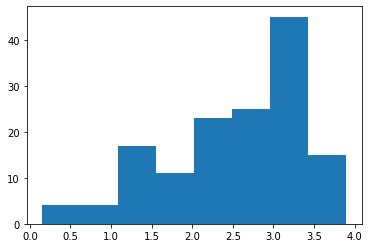

['data/anglophone/Gangsta/50Cent_JustALilBit.rap',
 'data/anglophone/Gangsta/JayZ_NiggasInParis.rap',
 'data/anglophone/Gangsta/LilWayne_AMilli.rap',
 'data/anglophone/Gangsta/SnoopDogg_Woof.rap',
 'data/anglophone/Gangsta/T.I._LiveYourLife.rap']

In [329]:
gangsta_error = []
summary_G = {'tempo':[],'meter':[], 'syl_onsets':[], 'syllabic_rate':[]}
for i, f in enumerate(gangsta_files):
    try:
        sample_path = sample_dir + 'Gangsta/' + f
        sample = HumdrumSummary(sample_path)
        df = sample.df
        summary_G['tempo'].append(sample.tempo)
        summary_G['meter'].append(sample.meter)
        summary_G['syl_onsets'].append(sample.syl_onsets)
        summary_G['syllabic_rate'].append(sample.syllabic_rate)
        print(sample_path)
        plt.hist(df[df['**rhyme']!='.'].cum_recip.apply(lambda x: x % 4), bins=8)
        plt.show()
    except:
        gangsta_error.append(sample_path)
        pass
gangsta_error

tempo


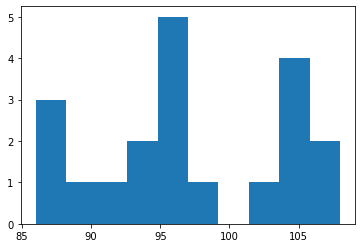

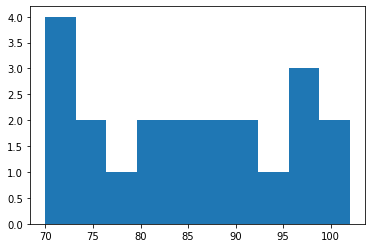

meter


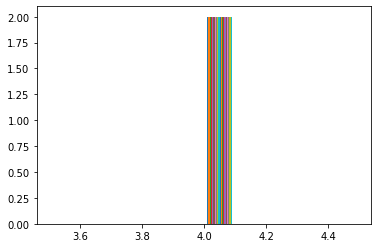

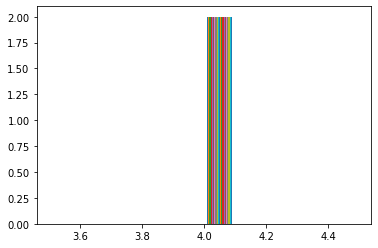

syl_onsets


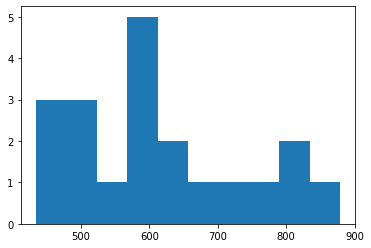

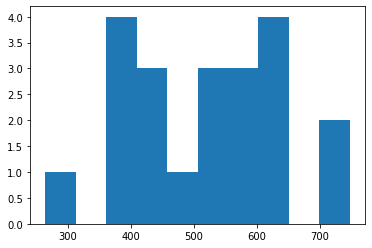

syllabic_rate


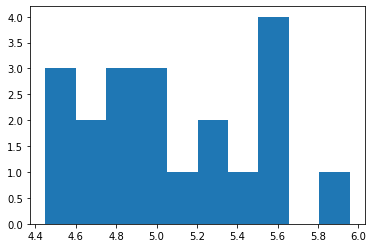

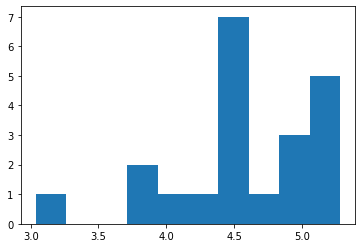

In [250]:
for i, summary_key in enumerate(summary_G.keys()):
    print(summary_key)
    plt.hist(summary_os[summary_key])
    plt.show()
    plt.hist(summary_G[summary_key])
    plt.show()

In [ ]:
# unused

'''



def rest_based(self, sample_clean):
        breaks_idx = sample_clean[sample_clean['**ipa']=='R'].index
        
        sample_flowwise = pd.DataFrame(columns=['recip','lyric'])
        for i in range(breaks_idx.shape[0]-1):
            (start, end) = (breaks_idx[i], breaks_idx[i+1])
            snippet = sample_clean.iloc[start:end]
            sample_flowwise.at[i,'recip'] = snippet['**recip'].values
            sample_flowwise.at[i,'lyric'] = ' '.join(snippet['**lyrics'].values)
            
            # convert into string, so that we can easily examine if the encoding is done correctly (we will check this with each song)
        maxlen = sample_flowwise.lyric.apply(lambda x: len(x)).max()
        pd.set_option('display.max_colwidth', maxlen)
        return sample_flowwise
        
        
        
        
'''